In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
from sklearn.decomposition import PCA
import pandas as pd

output_list.pt stores the stacked predictions of the test samples in the format of [#samples, #classes]; label_list stores the true labels of all samples in a list of length #samples;

In [2]:
from pandas.core import base
from utils import *  # bad practice, nvm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import NumpyDataset, TransformerEnsembleDataset, TrainSamplerMultiClass, TrainSampler, TrainSamplerMultiClassUnit
from models import AggregateFeatEnsemble, DynamicWeightEnsemble, LogisticRegression, BertClassiferHyperparams, SimpleEnsemble, FixedWeightEnsemble
from tqdm import tqdm
import time
import torch.nn.functional as F
from contrastive_utils import compute_sim_matrix, compute_target_matrix, contrastive_loss

ckpt_dir = 'exp_data'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wangyuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wangyuchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def load_dataset_dataframe(source):
    print("Loading and processing dataframe")

    dataset_path = "datasets"

    dataset_file_name = {
        "enron": 'full_enron.csv',
        "imdb": 'full_imdb_feat.csv',
        "imdb62": 'full_imdb62.csv',
        "blog": 'full_blog.csv',
        "ccat50": "ccat50-auth-index.csv"
    }

    df = None

    if source == "enron":
        df = pd.read_csv(os.path.join(dataset_path, dataset_file_name[source]))
        df['name'] = df['From'].apply(lambda x: x.split("'")[1].split(".")[0])
        df['name_in_mail'] = df.apply(lambda x: is_name_in_email(x['name'], x['content']), axis=1)
        df = df[df['name_in_mail'] == 0]
        df = df[df['content'].apply(lambda x: '-----' not in str(x))]
        df = df[df['content'].apply(lambda x: "@" not in str(x))]
        df = df[df['content'].apply(lambda x: "From: " not in str(x))]
        df = df[df['content'].apply(lambda x: len(str(x).split()) > 10)]
        df.to_csv(os.path.join(dataset_path, 'full_enron2.csv'))

    elif source == "imdb":
        feat_path = os.path.join(dataset_dir, "full_imdb_feat.csv")
        if os.path.isfile(feat_path):
            df = pd.read_csv(feat_path, index_col=0)
        else:
            # # Parallelize apply on Pandas
            from pandarallel import pandarallel
            pandarallel.initialize()

            df = pd.read_csv(os.path.join(dataset_dir, 'full_imdb.csv'), index_col=0)
            print("drop rows!!!!!!!!!!!!!")
            drop_count = 0
            for index, row in df.iterrows():
                # print(row['content'])
                if len(str(row['content'])) <= 3:
                    df.drop(index, inplace=True)
                    drop_count += 1
            print(f"dropped {drop_count} rows")
            print(df.shape)
            df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
            df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d",
                "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s",
                "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7",
                "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9",
                "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
            df.to_csv(feat_path)

    elif source == "imdb62":
        df = pd.read_csv(os.path.join(dataset_path, dataset_file_name[source]))
        df = pd.read_csv(os.path.join(dataset_dir, "full_imdb62.csv"), index_col=0)

    elif source == "blog":
        df = pd.read_csv(os.path.join(dataset_path, dataset_file_name[source]))

    elif source == "ccat50":
        feat_path = os.path.join(dataset_dir, "full_ccat50_feat.csv")
        if os.path.isfile(feat_path):
            df = pd.read_csv(feat_path, index_col=0)
        else:
            df = pd.read_csv(os.path.join(dataset_path, dataset_file_name[source]))
            from pandarallel import pandarallel
            pandarallel.initialize()
            df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
            df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d",
                    "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s",
                    "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7",
                    "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9",
                    "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
        df.to_csv(feat_path)
    return df

In [4]:
def build_train_test(df, source, limit, per_author=None):
    # Select top N senders and build Train and Test
    list_spk = list(pd.DataFrame(df['From'].value_counts()[:limit]).reset_index()['index'])

    sub_df = df[df['From'].isin(list_spk)]

    if per_author is not None:
        raise NotImplementedError()
    # if per_author is not None:
    #     sub_df = sub_df.groupby('From').head(per_author).reset_index(drop=True)
    #     print(f'build_train_test: only take the first {per_author} samples for each author')

    if source == 'ccat50':
         sub_df = sub_df[
        ['From', 'content', 'train', 'content_tfidf', "avg_len", "len_text", "len_words", "num_short_w", "per_digit",
         "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m",
         "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1",
         "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4",
         "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]]
    else:
        sub_df = sub_df[
            ['From', 'content', 'content_tfidf', "avg_len", "len_text", "len_words", "num_short_w", "per_digit",
            "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m",
            "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1",
            "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4",
            "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]]
    sub_df = sub_df.dropna()

    text = " ".join(sub_df['content'].values)
    list_bigram = return_best_bi_grams(text)
    list_trigram = return_best_tri_grams(text)

    print("Number of texts : ", len(sub_df))

    dict_nlp_enron = {}
    k = 0

    for val in np.unique(sub_df.From):
        dict_nlp_enron[val] = k
        k += 1

    sub_df['Target'] = sub_df['From'].apply(lambda x: dict_nlp_enron[x])


    if source == 'ccat50':
        full_train = sub_df[sub_df["train"] == 1]
        train_valid = train_test_split(full_train[['content', 'Target']], test_size=0.2, stratify=full_train['Target'],
                                    random_state=0)
        ind_train = list(train_valid[0].index)
        nlp_train = full_train.loc[ind_train]
        ind_val = list(train_valid[1].index)
        nlp_val = full_train.loc[ind_val]

        full_test = sub_df[sub_df["train"] == 0]
        nlp_test = full_test[['content', 'Target']]
    else:

        train_unseen = train_test_split(sub_df[['content', 'Target']], test_size=0.2, stratify=sub_df['Target'],
                                    random_state=0)
        ind_train = list(train_unseen[0].index)
        nlp_train = sub_df.loc[ind_train]

        val_test = train_test_split(nlp_train[['content', 'Target']], test_size=0.5, stratify=nlp_train['Target'],
                                random_state=0)
        ind_val = list(val_test[0].index)
        ind_test = list(val_test[1].index)
        nlp_val = sub_df.loc[ind_val]
        nlp_test = sub_df.loc[ind_test]

    return nlp_train, nlp_val, nlp_test, list_bigram, list_trigram

In [7]:
def test_bert(nlp_train, nlp_val, nlp_test, tqdm_on, return_features=True, model_name='microsoft/deberta-base', embed_len=768):

    print("#####")
    print("Training BERT")
    from models import LogisticRegression
    from dataset import BertDataset
    from models import BertClassifier

    tokenizer, extractor = None, None
    if 'bert-base' in model_name:
        from transformers import BertTokenizer, BertModel
        tokenizer = BertTokenizer.from_pretrained(model_name)
        extractor = BertModel.from_pretrained(model_name)
    elif 'deberta' in model_name:
        from transformers import DebertaTokenizer, DebertaModel
        tokenizer = DebertaTokenizer.from_pretrained(model_name)
        extractor = DebertaModel.from_pretrained(model_name)
    elif 'roberta' in model_name:  # roberta-base
        from transformers import RobertaTokenizer, RobertaModel
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        extractor = RobertaModel.from_pretrained(model_name)
    elif 'gpt2' in model_name:
        from transformers import GPT2Tokenizer, GPT2Model
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        extractor = GPT2Model.from_pretrained(model_name)
        tokenizer.pad_token = tokenizer.eos_token  # for gpt tokenizer only
    elif 'gpt' in model_name:  # 'openai-gpt'
        from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
        tokenizer = OpenAIGPTTokenizer.from_pretrained(model_name)
        extractor = OpenAIGPTModel.from_pretrained(model_name)
        tokenizer.pad_token = tokenizer.unk_token  # for gpt tokenizer only
        print(f'pad token {tokenizer.unk_token}')
    elif 'xlnet' in model_name:
        from transformers import XLNetTokenizer, XLNetModel
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
        extractor = XLNetModel.from_pretrained(model_name)
    else:
        raise NotImplementedError(f"model {model_name} not implemented")

    # freeze extractor
    for param in extractor.parameters():
        param.requires_grad = True

    # business logic
    train_x, train_y = nlp_train['content'].tolist(), nlp_train['Target'].tolist()
    val_x, val_y = nlp_val['content'].tolist(), nlp_val['Target'].tolist()
    test_x, test_y = nlp_test['content'].tolist(), nlp_test['Target'].tolist()

    # training setup
    num_epochs, base_lr, base_bs, ngpus, dropout = 1, 1e-5, 6, torch.cuda.device_count(), 0.35
    num_tokens, hidden_dim, out_dim = 256, 512, max(test_y) + 1
    model = BertClassifier(extractor, LogisticRegression(embed_len * num_tokens, hidden_dim, out_dim, dropout=dropout))
    model.load_state_dict(torch.load("1_val0.77983_test0.77983.pt"))
    model = nn.DataParallel(model).cuda()
    
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=base_lr * ngpus, weight_decay=3e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

    train_set = BertDataset(train_x, train_y, tokenizer, num_tokens)
    val_set = BertDataset(val_x, val_y, tokenizer, num_tokens)
    test_set = BertDataset(test_x, test_y, tokenizer, num_tokens)

    coefficient, temperature, sample_unit_size = 0.0, 0.1, 2
    print(f'coefficient, temperature, sample_unit_size = {coefficient, temperature, sample_unit_size}')

    # recorder
    exp_dir = os.path.join(ckpt_dir, f'{id}_{model_name.split("/")[-1]}_coe{coefficient}_temp{temperature}_unit{sample_unit_size}_epoch{num_epochs}')
    writer = SummaryWriter(os.path.join(exp_dir, 'board'))

    train_sampler = TrainSamplerMultiClassUnit(train_set, sample_unit_size=sample_unit_size)
    train_loader = DataLoader(train_set, batch_size=base_bs * ngpus, sampler=train_sampler, shuffle=False,
                              num_workers=4 * ngpus, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=base_bs * ngpus, shuffle=False, num_workers=4 * ngpus,
                            pin_memory=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=base_bs * ngpus, shuffle=False, num_workers=4 * ngpus,
                             pin_memory=True, drop_last=True)
    
    model.eval()
    pg = tqdm(test_loader, leave=False, total=len(val_loader), disable=not tqdm_on)
    output_list = torch.randn((6,10)).cuda()
    feature_list = torch.randn((6, 100)).cuda()
    label_list = []
    m = torch.nn.AvgPool2d((1, 2000), stride=(1, 1950))
    with torch.no_grad():
        test_acc_2 = AverageMeter()
        for i, (x1, x2, x3, y) in enumerate(pg):
            x, y = (x1.cuda(), x2.cuda(), x3.cuda()), y.cuda()
            pred, feats = model(x, return_feat=True)
            condensed_feats = m(feats.unsqueeze(0)).squeeze(0)
            if i == 0:
                output_list = pred
                feature_list = condensed_feats
                label_list = [y]
            else:
                output_list = torch.vstack((output_list, pred))
                feature_list = torch.vstack((feature_list, condensed_feats))
                label_list.append(y)


    torch.save(output_list, "output_list_1.pt")
    torch.save(label_list,"label_list_1.pt")
    torch.save(feature_list, "feature_list_1.pt")

In [9]:
source = "blog"
df = load_dataset_dataframe(source)
list_senders = [50]

if source == "imdb62":
        list_senders = [62]

# start testing
for limit in list_senders:
    print("Number of authors: ", limit)
    nlp_train, nlp_val, nlp_test, list_bigram, list_trigram = build_train_test(df, source, limit, per_author=None)
    test_bert(nlp_train, nlp_val,
                                                                                              nlp_test,
                                                                                              tqdm_on=True,
                                                                                              return_features=True,
                                                                                              model_name='microsoft/deberta-base')


Loading and processing dataframe
Number of authors:  50
Number of texts :  73275
#####
Training BERT


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'config', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Logistic Regression classifier of dim (196608 512 50)
coefficient, temperature, sample_unit_size = (0.0, 0.1, 2)
train sampler with sample unit size 2
from dataset sampler: original dataset size 58620, resampled dataset size 58598. sample unit size 2


In [11]:
output_list = torch.load("output_list_1.pt").cpu().numpy() # replace with your own output_list and label_list
feature_list = torch.load("feature_list_1.pt").cpu().numpy()
label_list = torch.load("label_list_1.pt")

truth_list = []
for l in label_list:
    l = l.cpu().numpy().astype(np.int32)
    truth_list = np.concatenate((truth_list, l))
truth_label = truth_list.astype(np.int64)
pred_label = np.argmax(output_list, axis=1)

In [12]:
len(truth_label)

29304

## Class-Wise Accuracy

In [13]:
n_classes = 50
class_acc_dic = {} # for each class's samples, how many are correctly predicted and how many are falsely predicted
for c in range(n_classes):
    class_acc_dic[c] = {}
    class_acc_dic[c]["T"] = 0
    class_acc_dic[c]["F"] = 0
for (tl, pl) in zip(truth_label, pred_label):
    if tl == pl:
        class_acc_dic[tl]["T"] += 1
    else:
        class_acc_dic[tl]["F"] += 1
        
for c in range(n_classes):
    acc = class_acc_dic[c]["T"] / (class_acc_dic[c]["T"] + class_acc_dic[c]["F"])
    print("class " + str(c) + " acc: " + str(acc))

class 0 acc: 1.0
class 1 acc: 0.9429223744292238
class 2 acc: 0.9980119284294234
class 3 acc: 0.07780320366132723
class 4 acc: 0.9955156950672646
class 5 acc: 0.9976580796252927
class 6 acc: 0.5797413793103449
class 7 acc: 0.9964539007092199
class 8 acc: 0.9950738916256158
class 9 acc: 0.9907063197026023
class 10 acc: 0.9994075829383886
class 11 acc: 0.998109640831758
class 12 acc: 0.05901639344262295
class 13 acc: 1.0
class 14 acc: 0.9983361064891847
class 15 acc: 0.09592326139088729
class 16 acc: 0.39869281045751637
class 17 acc: 1.0
class 18 acc: 0.9951100244498777
class 19 acc: 0.9953161592505855
class 20 acc: 1.0
class 21 acc: 1.0
class 22 acc: 1.0
class 23 acc: 0.9882352941176471
class 24 acc: 1.0
class 25 acc: 0.2935267857142857
class 26 acc: 0.05203252032520325
class 27 acc: 0.997737556561086
class 28 acc: 1.0
class 29 acc: 0.0196078431372549
class 30 acc: 0.983633387888707
class 31 acc: 0.7984322508398656
class 32 acc: 0.9908045977011494
class 33 acc: 0.9948652118100129
class 

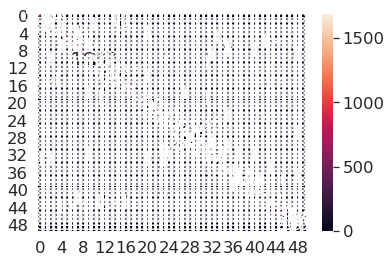

In [14]:
# use a smaller n_classes value to view better...[-.-]
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truth_label, pred_label)
f = sns.heatmap(cm, annot=True, fmt='d')

## Visualization

In [15]:
def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int64)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

def pca_visualize(pool, colors):
    time_start = time.time()

    pca = PCA(n_components=4)
    pca_result = pca.fit_transform(pool)

    print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

    pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

    pca_df['pca1'] = pca_result[:,0]
    pca_df['pca2'] = pca_result[:,1]
    pca_df['pca3'] = pca_result[:,2]
    pca_df['pca4'] = pca_result[:,3]

    print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

    top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
    
    scatter(top_two_comp.values,colors)
    
def tsne_visualize(pool, colors):
    RS = 123
    model_tsne = TSNE(random_state=RS).fit_transform(pool)
    scatter(model_tsne, colors)

In [16]:
viewed_samples = 29000 # number of points to be seen
pool = feature_list[:viewed_samples]
print(pool.shape)
colors = truth_label[:viewed_samples]
print(len(colors))

(29000, 100)
29000


In [17]:
# check out the unique colors included, make sure a consecutive list starting from 0 is included
print(np.unique(colors))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


PCA done! Time elapsed: 0.11576986312866211 seconds
Variance explained per principal component: [0.21574093 0.06388073 0.05824719 0.04258772]


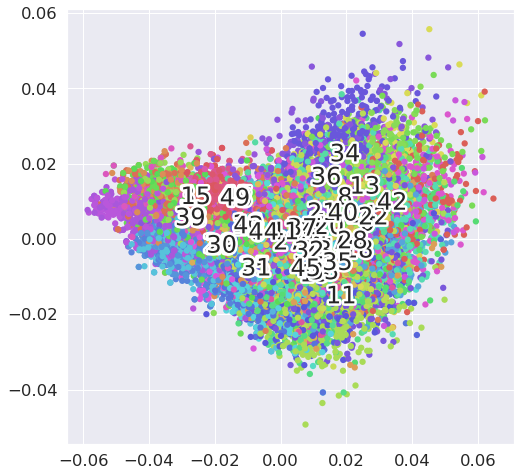

In [18]:
# sample run of pca
pca_visualize(pool, colors)

In [ ]:
# sample run of tsne
tsne_visualize(pool, colors)

## Prepare Dataset

In [ ]:
# import os
# import csv

# authors = os.listdir("./C50/C50train")
# for a in authors:
#     if not os.path.isdir("./C50/C50train/" + a):
#         print(a)
#         os.remove("./C50/C50train/" + a)
# len(authors)

# authors_test = os.listdir("./C50/C50test")
# for at in authors_test:
#     if not os.path.isdir("./C50/C50test/" + at):
#         print(at)
#         os.remove("./C50/C50test/" + at)
#     if at not in authors:
#         print(at)
# len(authors_test)

# header = ['index', 'author', 'title', 'train', 'content']
# table_name = "./datasets/ccat50"
# f = open(table_name + ".csv", 'w', encoding='UTF8')
# writer = csv.writer(f)
# writer.writerow(header)

# for a in authors:
#     articles_train = os.listdir("./C50/C50train/" + a)
#     articles_test = os.listdir("./C50/C50test/" + a)
#     for art_train in articles_train:
#         if not art_train.endswith('.txt'):
#             continue
#         file = open("./C50/C50train/" + a + "/" + art_train)
#         line = file.read().replace("\n", " ")
#         file.close()
#         writer.writerow(['', a, art_train[:-4], 1, line])
#     for art_test in articles_test:
#         if not art_test.endswith('.txt'):
#             continue
#         file = open("./C50/C50test/" + a + "/" + art_test)
#         line = file.read().replace("\n", " ")
#         file.close()
#         writer.writerow(['', a, art_train[:-4], 0, line])
# f.close()